In [1]:
import xarray as xr
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sea_breeze import load_obs
import pandas as pd
import datetime as dt

In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42861 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45345' processes=7 threads=14, memory=63.00 GiB>

In [3]:
models=["aus2200_smooth_s4","barra_c_smooth_s2","barra_r","era5"]

F_list = [] 
sbi_list = []
fuzzy_list = []
F_mask_list = []
sbi_mask_list = []
fuzzy_mask_list = []

for model in models:

    print(model)

    if model in ["aus2200_smooth_s4","era5"]:
        sbi_list.append(utils.load_diagnostics("sbi",model))
    else:
        sbi_list.append(np.nan)
    F_list.append(utils.load_diagnostics("F",model))
    fuzzy_list.append(utils.load_diagnostics("fuzzy",model))

    if model in ["aus2200_smooth_s4","era5"]:
        sbi_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_sbi_2*",
                      engine="zarr").mask)
    else:
        sbi_mask_list.append(np.nan)
    F_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_F_2*",
                      engine="zarr").mask)
    fuzzy_mask_list.append(xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+model+"/filters/filtered_mask_no_hourly_change_fuzzy_2*",
                      engine="zarr").mask)

aus2200_smooth_s4
barra_c_smooth_s2
barra_r
era5


In [4]:
def plot_obs_fuzzy(obs_fuzzy,ax,time,fuzzy_levels):
    
    obs_fuzzy.sel(station=
            (obs_fuzzy.lati.values>=lat_slice.start) &\
            (obs_fuzzy.lati.values<=lat_slice.stop) &\
            (obs_fuzzy.long.values>=lon_slice.start) &\
            (obs_fuzzy.long.values<=lon_slice.stop)).dropna("station").plot.scatter(
        ax=ax,x="long",y="lati",hue="__xarray_dataarray_variable__",
        levels=fuzzy_levels,cmap="Blues",edgecolor="k",add_colorbar=False)

def plot_case(ax, diagnostic, mask, u, v, angle_var, orog, lsm, levels, scale, cmap=None, extend=None, plot_uv=True, draw_labels=["left"],stn_lat=None,stn_lon=None):

    c = diagnostic.plot(
        ax=ax,
        cmap=cmap,
        levels=levels,
        extend=extend,add_colorbar=False)
    xr.plot.contour(
        mask,
        levels=1,
        colors="k",
        ax=ax)
    if plot_uv:
        xr.Dataset({"u":u,"v":v}).plot.quiver(
            ax=ax,
            x="lon",
            y="lat",
            u="u",
            v="v",
            scale=scale,
            width=0.006,
            add_guide=False)
        xr.plot.contour(
            lsm,
            levels=1,
            colors="k",
            linewidths=0.5,
            ax=ax)
        xr.plot.contourf(
            angle_var,
            ax=ax,
            levels=[0.5,1],
            extend="neither",
            colors=["none"],
            alpha=0,
            hatches=["...."],
            add_colorbar=False)
    else:
        ax.coastlines()
    xr.plot.contourf(
        orog,
        ax=ax,
        levels=[500,10000],
        extend="neither",
        colors=["grey"],
        alpha=0.6,
        hatches=["//"],
        add_colorbar=False)

    if (stn_lat is None) | (stn_lon is None):
        pass
    else:
        ax.plot(stn_lon,stn_lat,marker="o",ms=12,mfc="none",color="k",mew=2)
    
    ax.gridlines(draw_labels=draw_labels,ls=":",xlabel_style={"rotation":30})

    return c

def plot_driver(scale=150,stn_id=None):

    #################
    #LOAD MODEL DATA#
    #################
    aus2200_angle_ds, _, aus2200_uas, aus2200_vas, _, aus2200_vprime, _ = utils.load_aus2200_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path,
        exp_id)
    aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static(exp_id,lon_slice,lat_slice)
    
    barra_c_angle_ds, _, barra_c_uas, barra_c_vas, _, _, _ = utils.load_barra_c_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    barra_c_orog, barra_c_lsm = load_model_data.load_barra_static("AUST-04",lon_slice, lat_slice)
    
    barra_r_angle_ds, _, barra_r_uas, barra_r_vas, _, _, _ = utils.load_barra_r_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    barra_r_orog, barra_r_lsm = load_model_data.load_barra_static("AUS-11",lon_slice, lat_slice)
    
    era5_angle_ds, _, era5_uas, era5_vas, _, era5_vprime, _ = utils.load_era5_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    era5_orog, era5_lsm, _ = load_model_data.load_era5_static(lon_slice, lat_slice, time, time)    

    ###############
    #LOAD OBS DATA#
    ###############
    stn_obs = xr.concat([load_obs.load_half_hourly_stn_obs(s, slice(
                          pd.to_datetime(time) - dt.timedelta(hours=12),
                          pd.to_datetime(time) + dt.timedelta(hours=12))) for s in state], 
                        dim="station")
    if stn_id is not None:
        stn_lat=stn_obs.sel(station=stn_obs.bmid == stn_id).lati.values
        stn_lon=stn_obs.sel(station=stn_obs.bmid == stn_id).long.values
    else:
        stn_lat=None
        stn_lon=None
    # stn_theta = aus2200_angle_ds.sel(
    #     lat=stn_lat,
    #     lon=stn_lon,method="nearest").angle_interp.values
    #obs_fuzzy = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/stn_obs/fuzzy_201301010000_201802282300.zarr/").sel(time=time)

    ##################
    #CALCULATE VPRIME#
    ##################   
    # uprime, vprime = sea_breeze_funcs.rotate_wind(
    #     stn_obs.sel(station=stn_obs.bmid == stn_id).u,
    #     stn_obs.sel(station=stn_obs.bmid == stn_id).v,
    #     stn_theta)
    
    # aus2200_uprime, aus2200_vprime = sea_breeze_funcs.rotate_wind(
    #     aus2200_uas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
    #     aus2200_vas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
    #     aus2200_angle_ds.angle_interp.sel(lat=stn_lat,lon=stn_lon,method="nearest"))

    #################
    #SET UP PLOTTING#
    #################
    F_levels=[-100,-50,-20,-10,-5,-2,2,5,10,20,50,100]
    sbi_levels=np.linspace(0,1,11)
    fuzzy_levels=np.linspace(0,0.5,11)

    aus2200_coarsen_u = int(np.round((lon_slice.stop-lon_slice.start) * 8 / 2.2))
    aus2200_coarsen_v = int(np.round((lat_slice.stop-lat_slice.start) * 8 / 2.2))
    barra_c_coarsen_u = int(np.round((lon_slice.stop-lon_slice.start) * 8 / 4))
    barra_c_coarsen_v = int(np.round((lat_slice.stop-lat_slice.start) * 8 / 4))
    barra_r_coarsen_u = int(np.round((lon_slice.stop-lon_slice.start) * 8 / 12))
    barra_r_coarsen_v = int(np.round((lat_slice.stop-lat_slice.start) * 8 / 12))
    era5_coarsen_u = int(np.round((lon_slice.stop-lon_slice.start) * 8 / 25))
    era5_coarsen_v = int(np.round((lat_slice.stop-lat_slice.start) * 8 / 25))
    
    ###########
    # AUS2200 #
    ###########
    
    ax=plt.subplot(3,4,1,projection=ccrs.PlateCarree())
    c_F = plot_case(
        ax,
        F_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        scale=scale,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("AUS2200")
    
    ax=plt.subplot(3,4,9,projection=ccrs.PlateCarree())
    c_sbi = plot_case(
        ax,
        sbi_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        sbi_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        scale=scale,
        levels=sbi_levels,
        cmap="Blues",
        draw_labels=["left","bottom"],
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("AUS2200")
    
    ax=plt.subplot(3,4,5,projection=ccrs.PlateCarree())
    c_fuzzy = plot_case(
        ax,
        fuzzy_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
        aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
        aus2200_angle_ds.variance_interp,
        aus2200_orog,
        aus2200_lsm,
        scale=scale,
        levels=fuzzy_levels,
        extend="max",
        cmap="Blues",
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    #plot_obs_fuzzy(obs_fuzzy,ax,time,fuzzy_levels)
    plt.title("")

    
    ###########
    # BARRA-C #
    ###########
    
    ax=plt.subplot(3,4,2,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        barra_c_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_c_coarsen_v,"lon":barra_c_coarsen_u},boundary="pad").mean(),
        barra_c_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_c_coarsen_v,"lon":barra_c_coarsen_u},boundary="pad").mean(),
        barra_c_angle_ds.variance_interp,
        barra_c_orog,
        barra_c_lsm,
        scale=scale,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        plot_uv=True,
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("BARRA-C")
    
    ax=plt.subplot(3,4,6,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[1].sel(time=time,lat=lat_slice,lon=lon_slice),
        barra_c_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_c_coarsen_v,"lon":barra_c_coarsen_u},boundary="pad").mean(),
        barra_c_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_c_coarsen_v,"lon":barra_c_coarsen_u},boundary="pad").mean(),
        barra_c_angle_ds.variance_interp,
        barra_c_orog,
        barra_c_lsm,
        scale=scale,
        levels=fuzzy_levels,
        cmap="Blues",
        plot_uv=True,
        draw_labels=["left"],
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    #plot_obs_fuzzy(obs_fuzzy,ax,time,fuzzy_levels)
    plt.title("")
    
    ###########
    # BARRA-R #
    ###########
    
    ax=plt.subplot(3,4,3,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        barra_r_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_r_coarsen_v,"lon":barra_r_coarsen_u},boundary="pad").mean(),
        barra_r_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_r_coarsen_v,"lon":barra_r_coarsen_u},boundary="pad").mean(),
        barra_r_angle_ds.variance_interp,
        barra_r_orog,
        barra_r_lsm,
        scale=scale,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        plot_uv=True,
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("BARRA-R")
    
    #ax=plt.subplot(3,4,11,projection=ccrs.PlateCarree())
    
    ax=plt.subplot(3,4,7,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[2].sel(time=time,lat=lat_slice,lon=lon_slice),
        barra_r_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_r_coarsen_v,"lon":barra_r_coarsen_u},boundary="pad").mean(),
        barra_r_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":barra_r_coarsen_v,"lon":barra_r_coarsen_u},boundary="pad").mean(),
        barra_r_angle_ds.variance_interp,
        barra_r_orog,
        barra_r_lsm,
        scale=scale,
        levels=fuzzy_levels,
        cmap="Blues",
        plot_uv=True,
        draw_labels=["bottom","left"],
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    #plot_obs_fuzzy(obs_fuzzy,ax,time,fuzzy_levels)
    plt.title("")
    
    ###########
    #  ERA5   #
    ###########
    ax=plt.subplot(3,4,4,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        F_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        F_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        scale=scale,
        levels=F_levels,
        cmap="RdBu",
        extend="both",
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("ERA5")
    
    ax=plt.subplot(3,4,10,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        sbi_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        sbi_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        scale=scale,
        levels=sbi_levels,
        cmap="Blues",
        draw_labels=["bottom","left"],
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    plt.title("ERA5")
    
    ax=plt.subplot(3,4,8,projection=ccrs.PlateCarree())
    plot_case(
        ax,
        fuzzy_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        fuzzy_mask_list[3].sel(time=time,lat=lat_slice,lon=lon_slice),
        era5_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":era5_coarsen_v,"lon":era5_coarsen_u},boundary="pad").mean(),
        era5_angle_ds.variance_interp,
        era5_orog/9.8,
        era5_lsm,
        scale=scale,
        levels=fuzzy_levels,
        cmap="Blues",
        stn_lat=stn_lat,
        stn_lon=stn_lon)
    #plot_obs_fuzzy(obs_fuzzy,ax,time,fuzzy_levels)
    plt.title("")

    ###########
    #  OBS   #
    ###########
    # ax=plt.subplot(3,4,11)
    # vprime.sel(time=vprime.time.dt.minute==0).plot(marker="o")
    # aus2200_vprime.plot(marker="o")    
    # plt.title("")
    # plt.xticks(rotation=30)

    
    ax=plt.subplot(3,4,12,projection=ccrs.PlateCarree())
    q=stn_obs.sel(time=time,station=
        (stn_obs.lati>=lat_slice.start) &\
        (stn_obs.lati<=lat_slice.stop) &\
        (stn_obs.long>=lon_slice.start) &\
        (stn_obs.long<=lon_slice.stop)).plot.quiver(x="long",y="lati",u="u",v="v",scale=scale,width=0.006,add_guide=False)
    qk = plt.quiverkey(q,0.9,0.9,5,"5 m/s",coordinates="axes")
    ax.coastlines(lw=0.5)
    ax.set_xlim([lon_slice.start,lon_slice.stop])
    ax.set_ylim([lat_slice.start,lat_slice.stop])    
    ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"rotation":30})
    plt.title("Station wind observations")

    cb_f = plt.colorbar(c_F,plt.axes([0.9,0.66,0.01,0.2]))
    cb_fuzzy = plt.colorbar(c_fuzzy,plt.axes([0.9,0.39,0.01,0.2]))
    cb_sbi = plt.colorbar(c_sbi,plt.axes([0.5,0.12,0.01,0.2]))
    cb_f.set_label("F [ (g/kg)/100 km/3h ]")
    cb_sbi.set_label("SBI")
    cb_fuzzy.set_label("H")

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

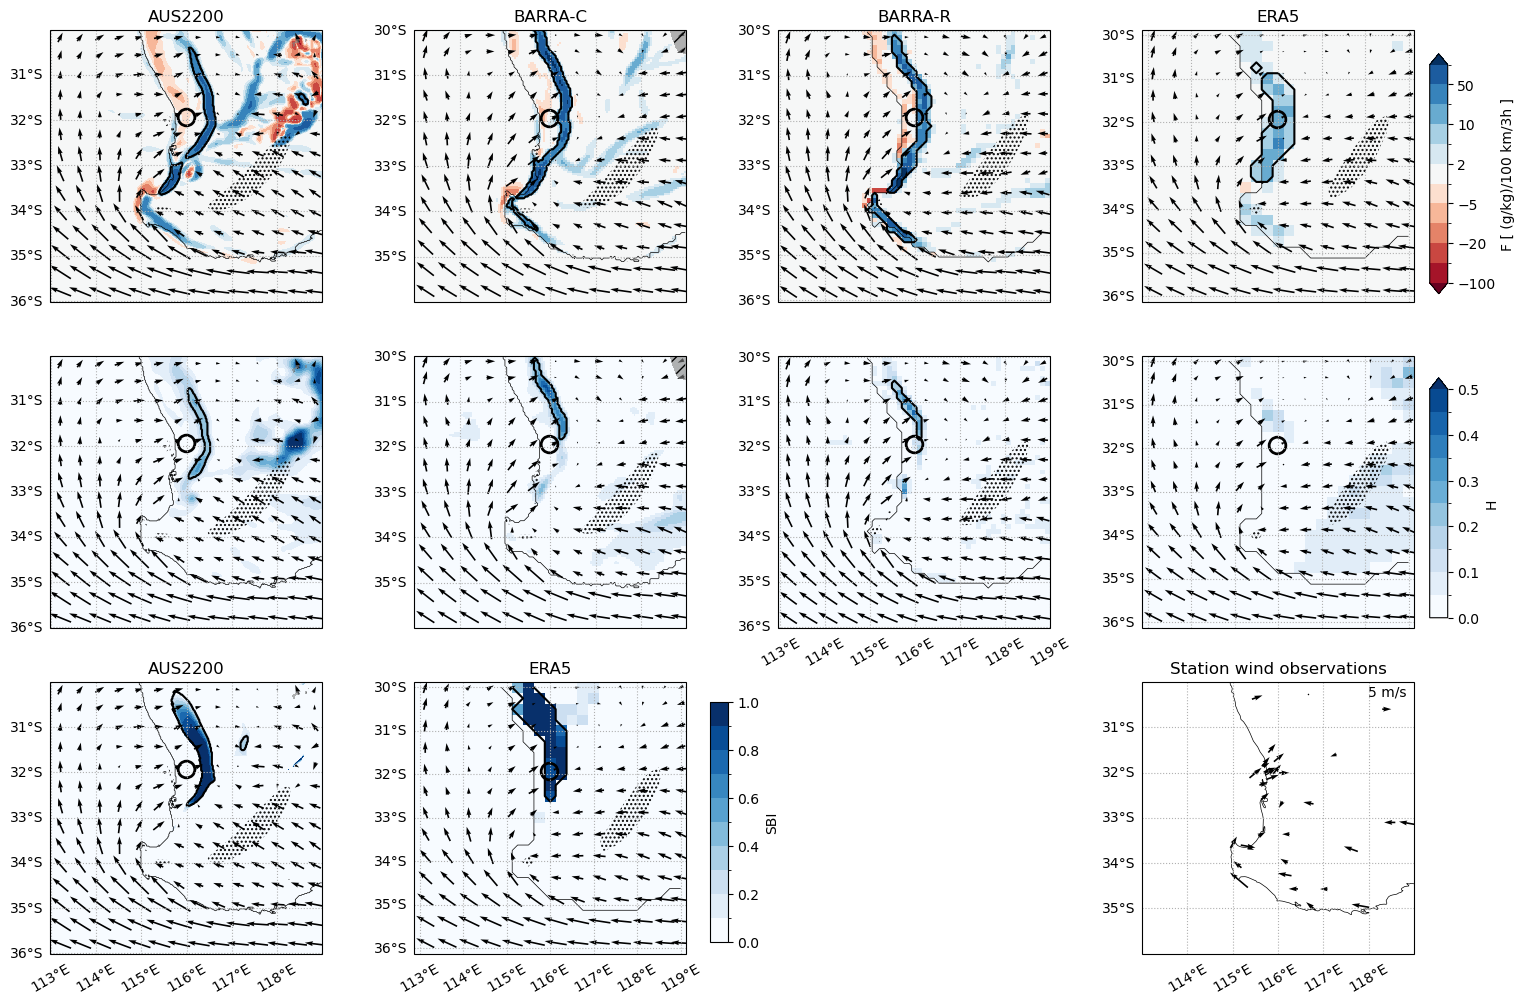

In [5]:
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
time = "2016-01-06 08:00"
exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"
state=["WA"]
stn_id=9021

plt.figure(figsize=[18,12])
plot_driver(stn_id=stn_id)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/perth1.jpeg",bbox_inches="tight",dpi=500)

In [6]:
# #Have a look at RH for this case

# import metpy.calc as mpcalc

# lat_slice = slice(-36,-30)
# lon_slice = slice(113,119)
# time = "2016-01-06 08:00"

# ta = load_model_data.load_aus2200_variable("ta",time,time,exp_id,lon_slice,lat_slice,"1hr",hgt_slice=slice(0,10)).sel(lev=5)
# hus = load_model_data.load_aus2200_variable("hus",time,time,exp_id,lon_slice,lat_slice,"1hr",hgt_slice=slice(0,10)).sel(lev=5)
# p = load_model_data.load_aus2200_variable("pfull",time,time,exp_id,lon_slice,lat_slice,"1hr",hgt_slice=slice(0,10)).sel(lev=5)

# mpcalc.relative_humidity_from_specific_humidity(p,ta,hus).plot(levels=10)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

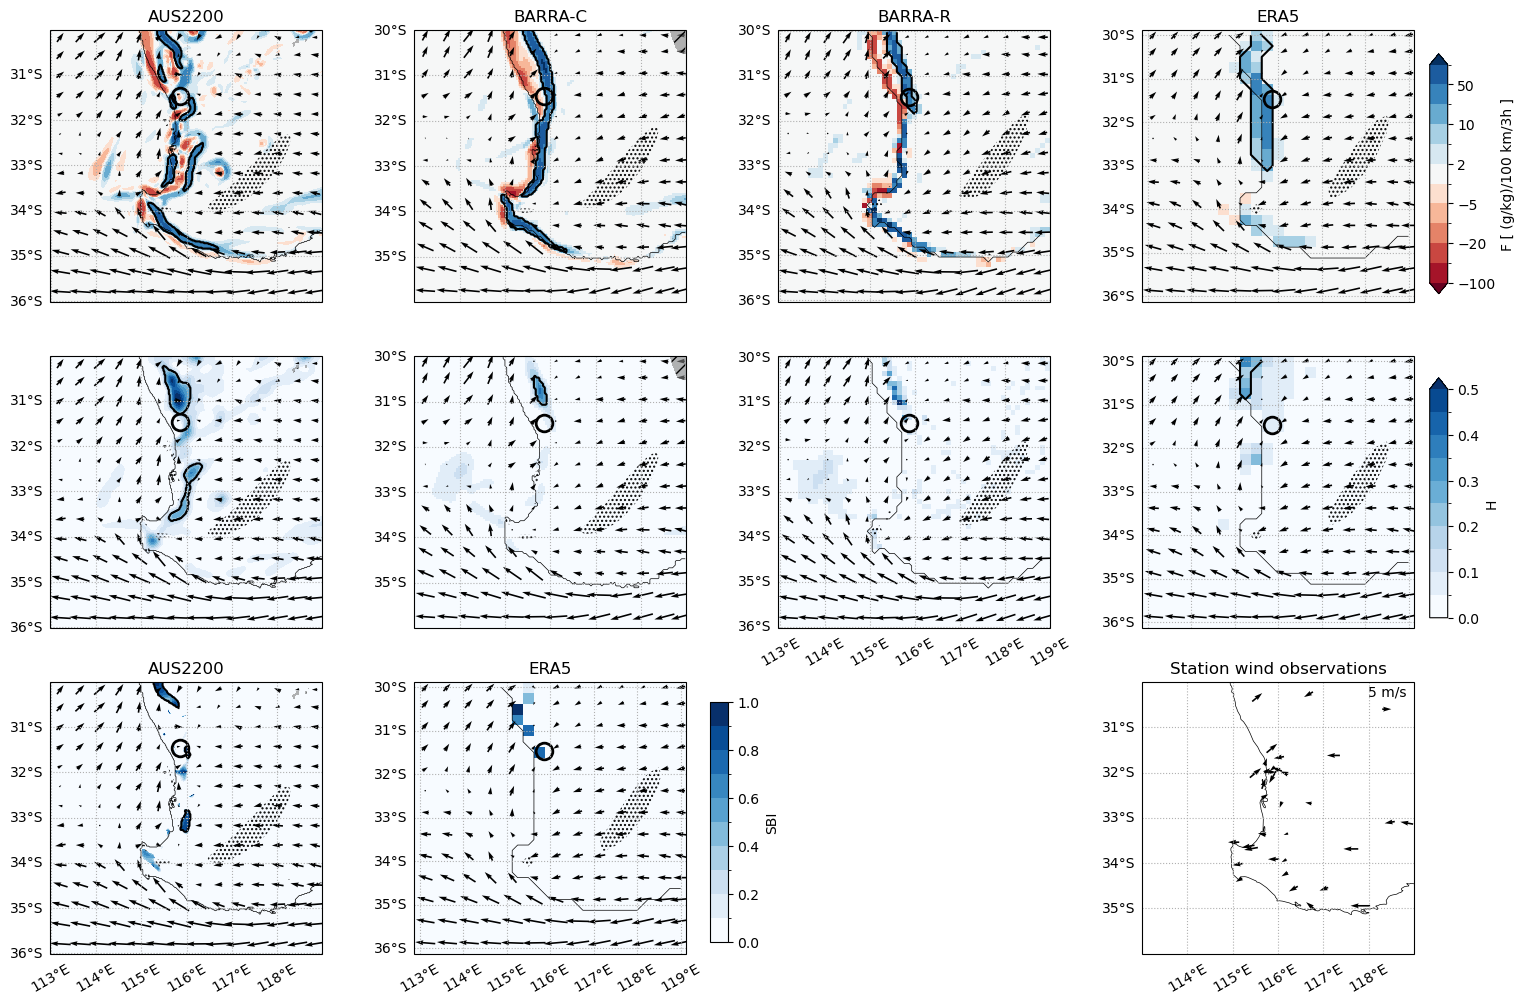

In [7]:
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
time = "2016-01-07 07:00"
exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"
state=["WA"]

plt.figure(figsize=[18,12])
plot_driver(stn_id=9178,scale=150)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/perth2.jpeg",bbox_inches="tight",dpi=500)

In [8]:
# lat_slice = slice(-16.5,-10.5)
# lon_slice = slice(127,133)
# time = "2016-01-08 05:00"
# exp_id = "mjo-elnino2016"
# base_path = "/g/data/ng72/ab4502/"
# state=["NT","WA"]

# plot_driver(scale=100)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

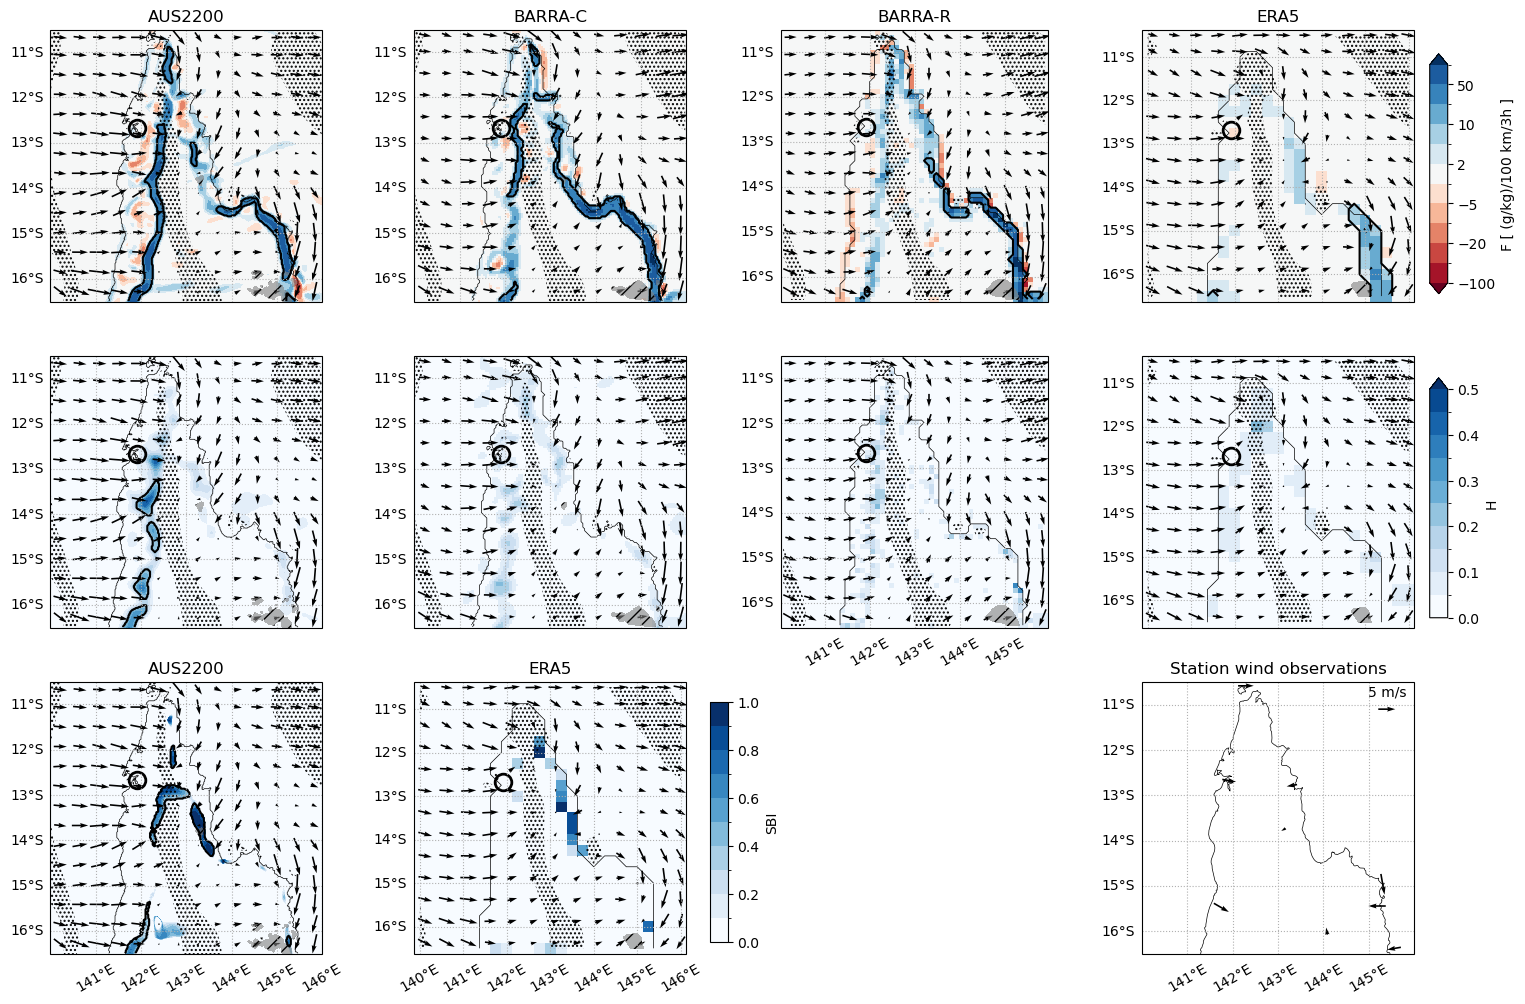

In [9]:
lat_slice = slice(-16.5,-10.5)
lon_slice = slice(140,146)
time = "2016-01-07 06:00"

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"
state = ["QLD"]

plt.figure(figsize=[18,12])
plot_driver(stn_id=27045,scale=80)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/cape_york.jpeg",bbox_inches="tight",dpi=500)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

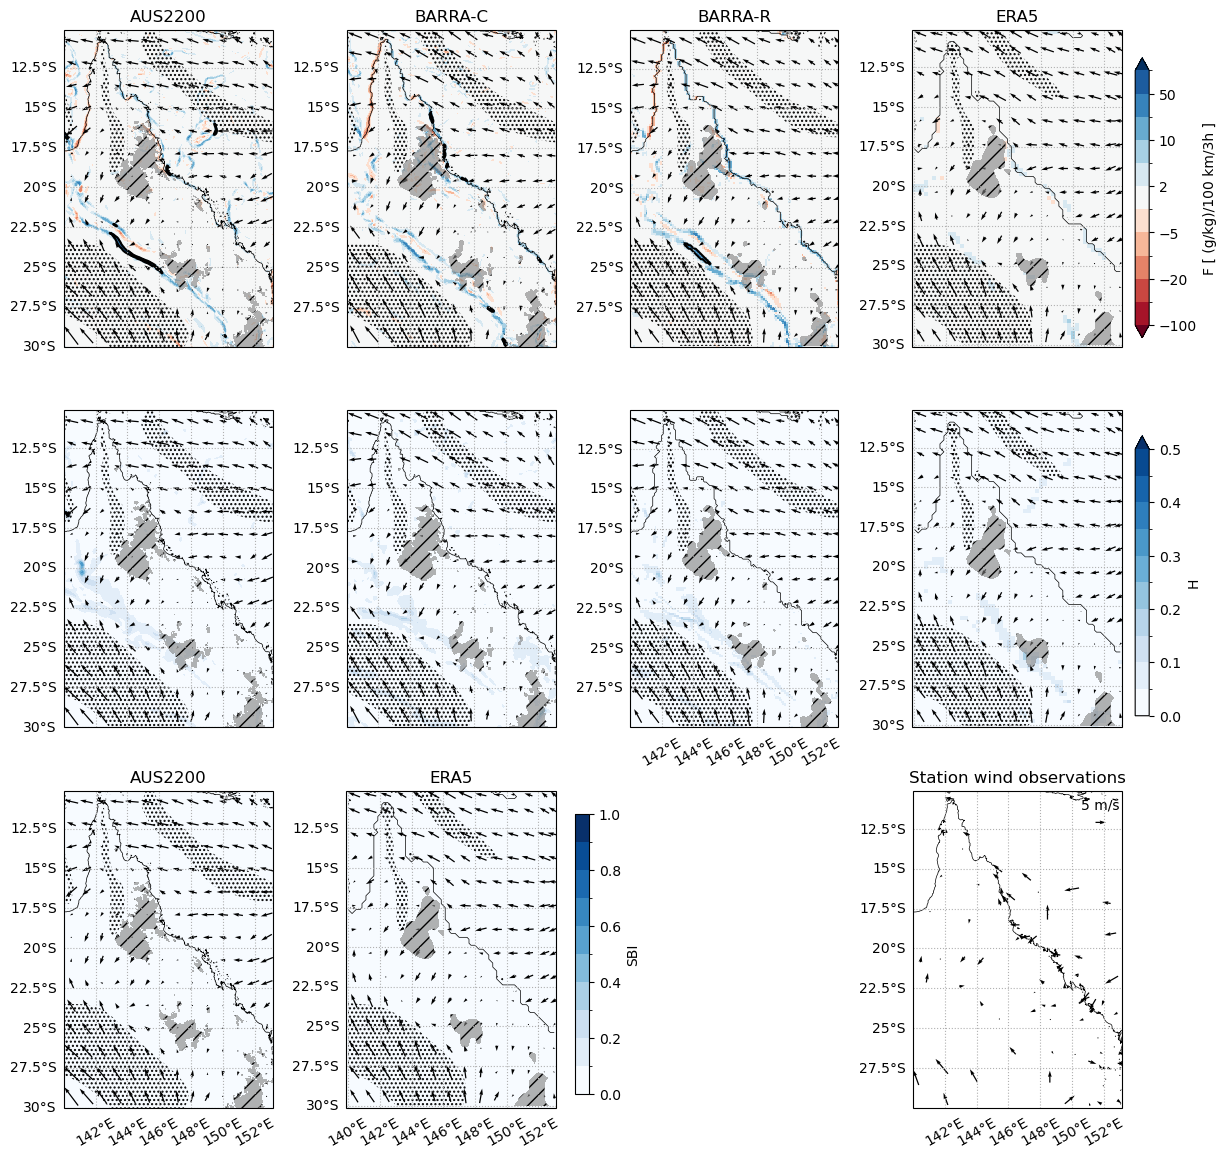

In [10]:
lat_slice = slice(-30,-10.1)
lon_slice = slice(140,153.1)
time = "2016-01-14 20:00"

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

state=["QLD","SA","NSW-ACT"]

plt.figure(figsize=[14,14])
plot_driver(scale=100)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/qld.jpeg",bbox_inches="tight",dpi=500)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

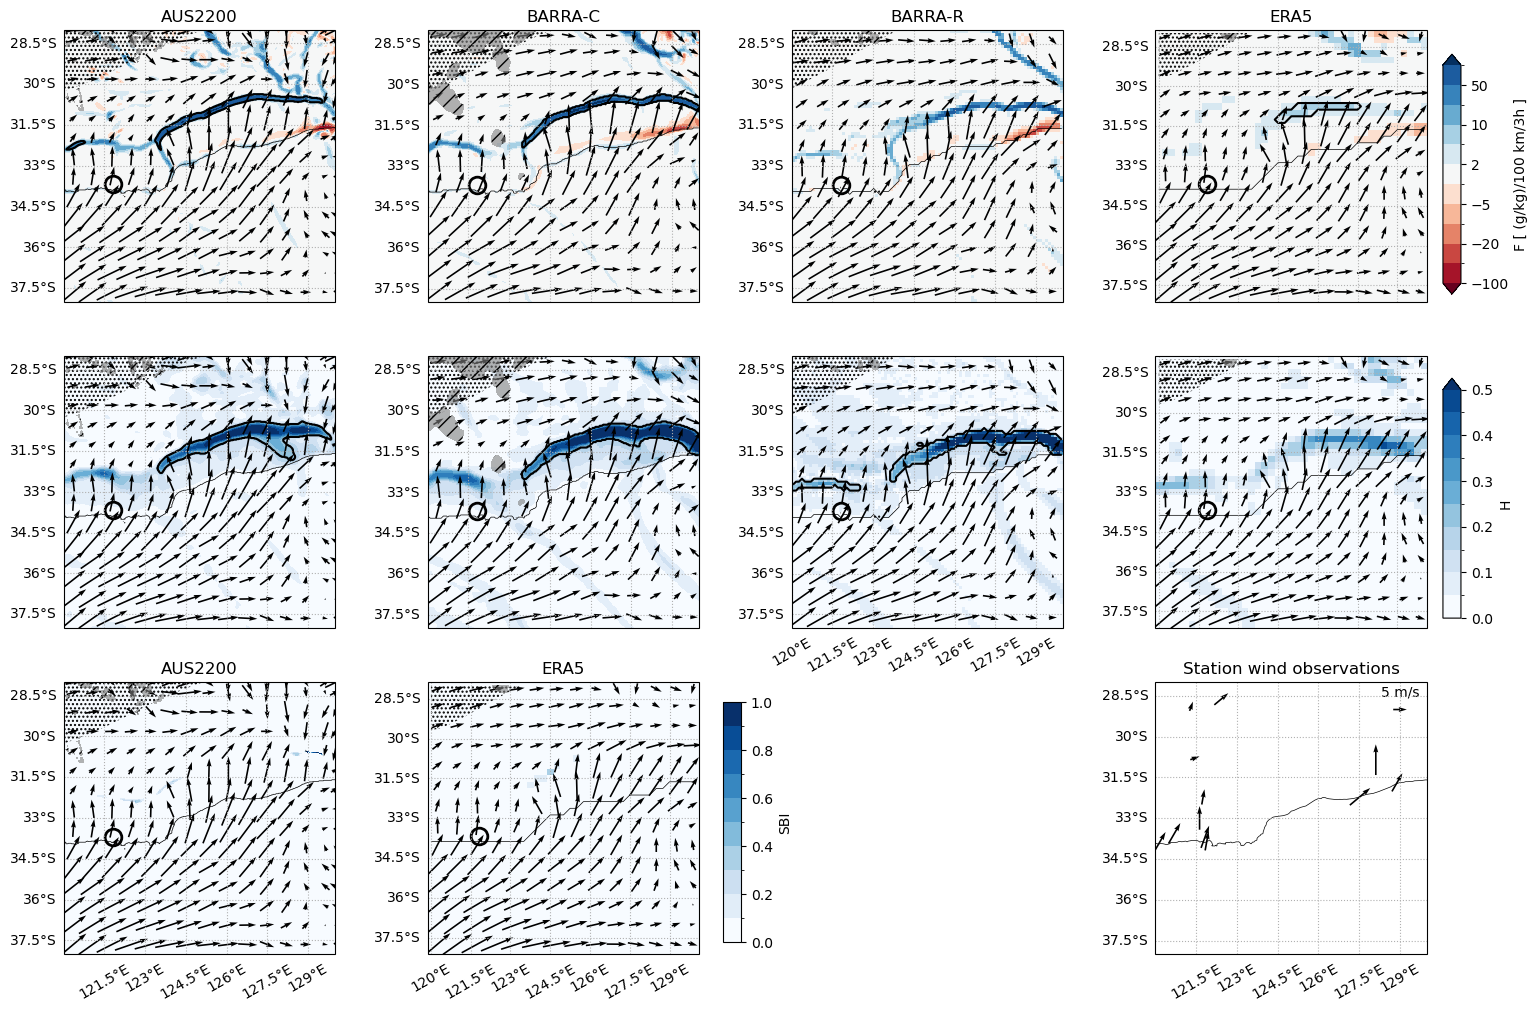

In [11]:
# lat_slice = slice(-40,-20)
# lon_slice = slice(110,135)
lat_slice = slice(-38,-28)
lon_slice = slice(120,130)
time = "2016-01-12 09:00"

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

state = ["WA","SA","NT"]

plt.figure(figsize=[18,12])
plot_driver(scale=100,stn_id=9542)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/nullabor.jpeg",bbox_inches="tight",dpi=500)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

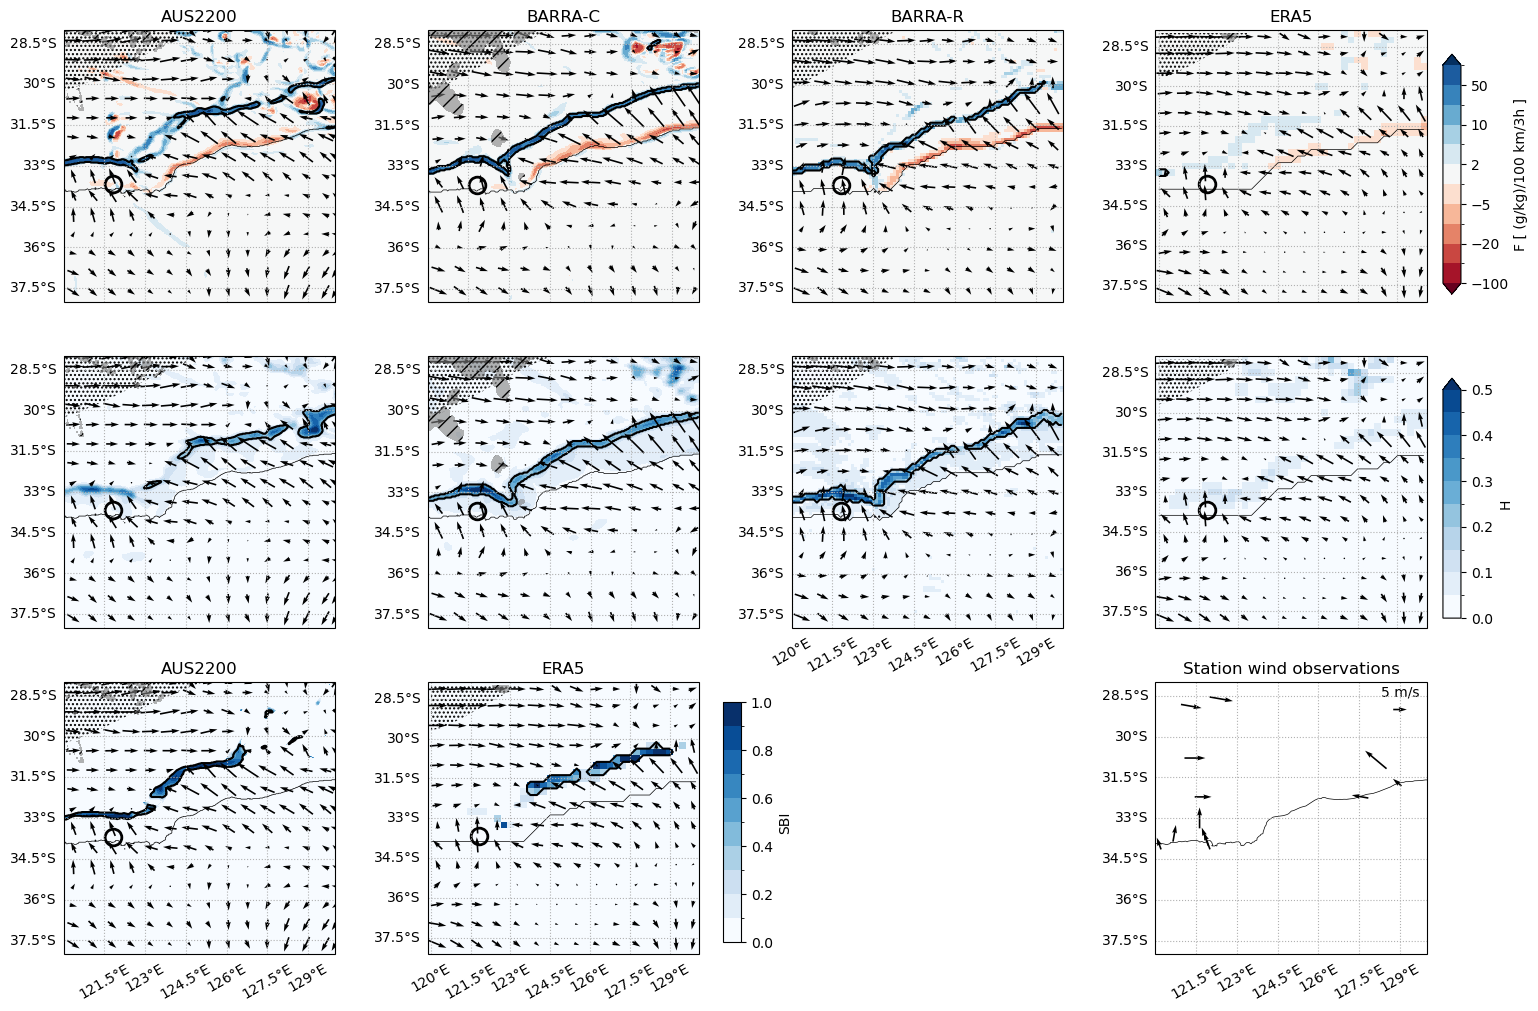

In [12]:
# lat_slice = slice(-40,-20)
# lon_slice = slice(110,135)
lat_slice = slice(-38,-28)
lon_slice = slice(120,130)
time = "2016-01-11 09:00"

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

state = ["WA","SA","NT"]

plt.figure(figsize=[18,12])
plot_driver(scale=100,stn_id=9542)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/nullabor2.jpeg",bbox_inches="tight",dpi=500)

In [13]:
# lat_slice = slice(-40,-20)
# lon_slice = slice(110,135)
# time = "2016-01-11 14:00"

# exp_id = "mjo-elnino2016"
# base_path = "/g/data/ng72/ab4502/"

# state = ["WA","SA","NT"]

# plot_driver(scale=100)


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

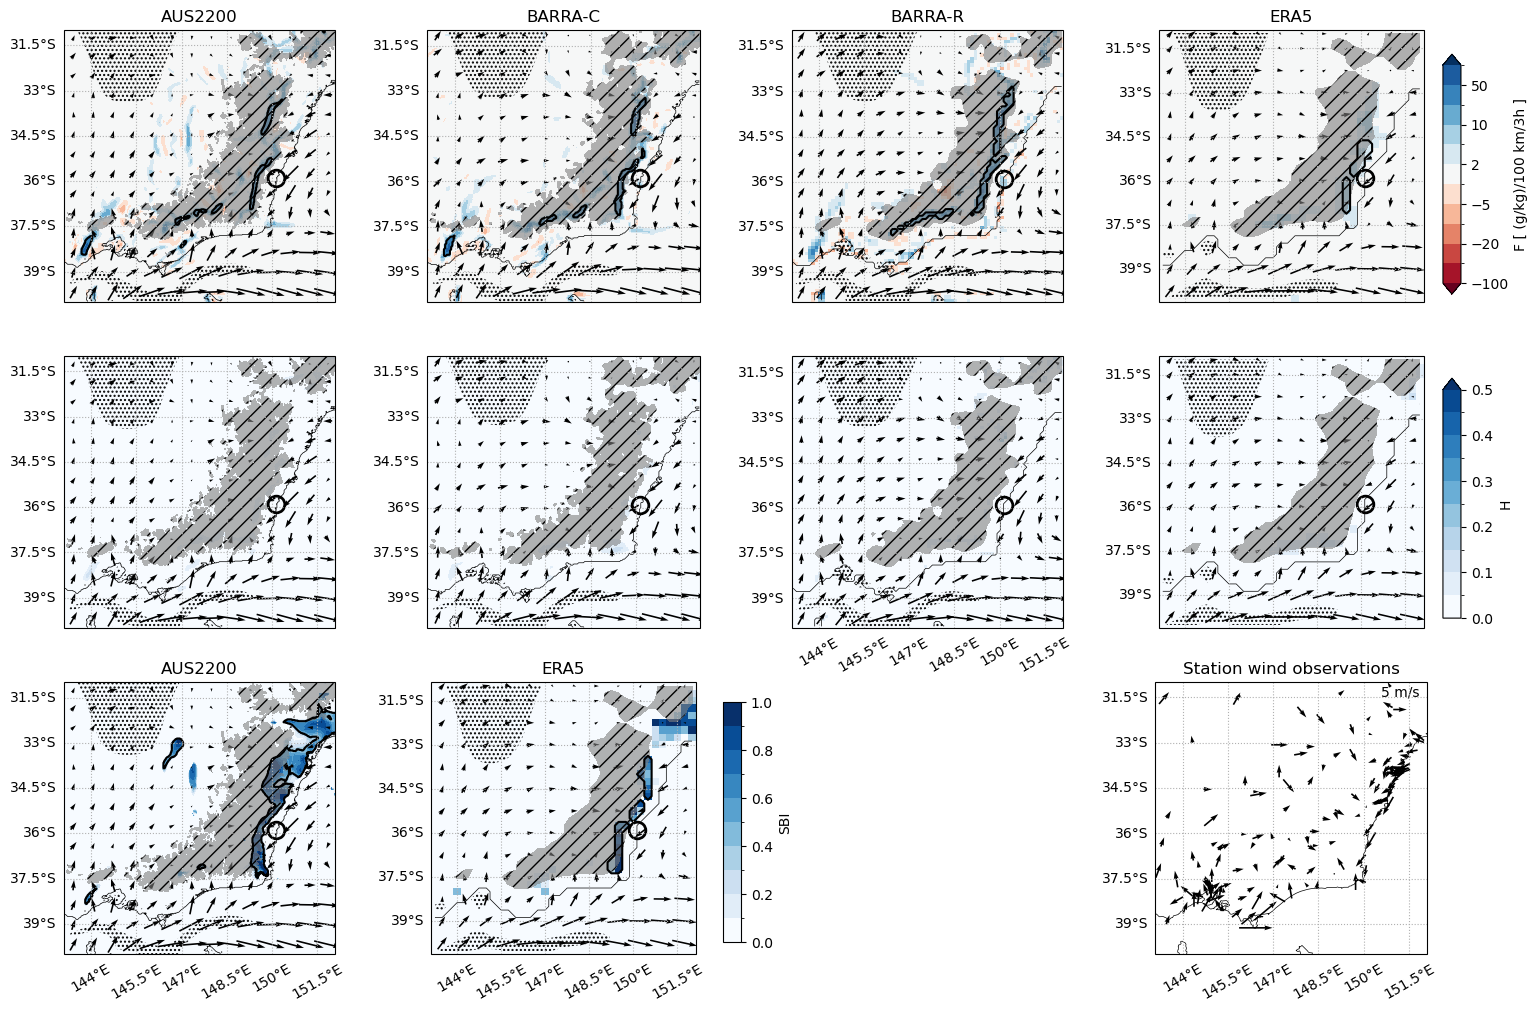

In [13]:
lat_slice = slice(-40,-31)
lon_slice = slice(143.1,152.1)
time = "2016-01-09 04:00"

state = ["VIC","NSW-ACT"]

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

plt.figure(figsize=[18,12])
plot_driver(scale=100,stn_id=69148)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/east_coast.jpeg",bbox_inches="tight",dpi=500)

In [15]:
# lat_slice = slice(-30.1,-10.1)
# lon_slice = slice(110,135)
# time = "2016-01-02 05:00"

# exp_id = "mjo-elnino2016"
# base_path = "/g/data/ng72/ab4502/"

# state = ["NT","WA"]

# plot_driver(scale=150)


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

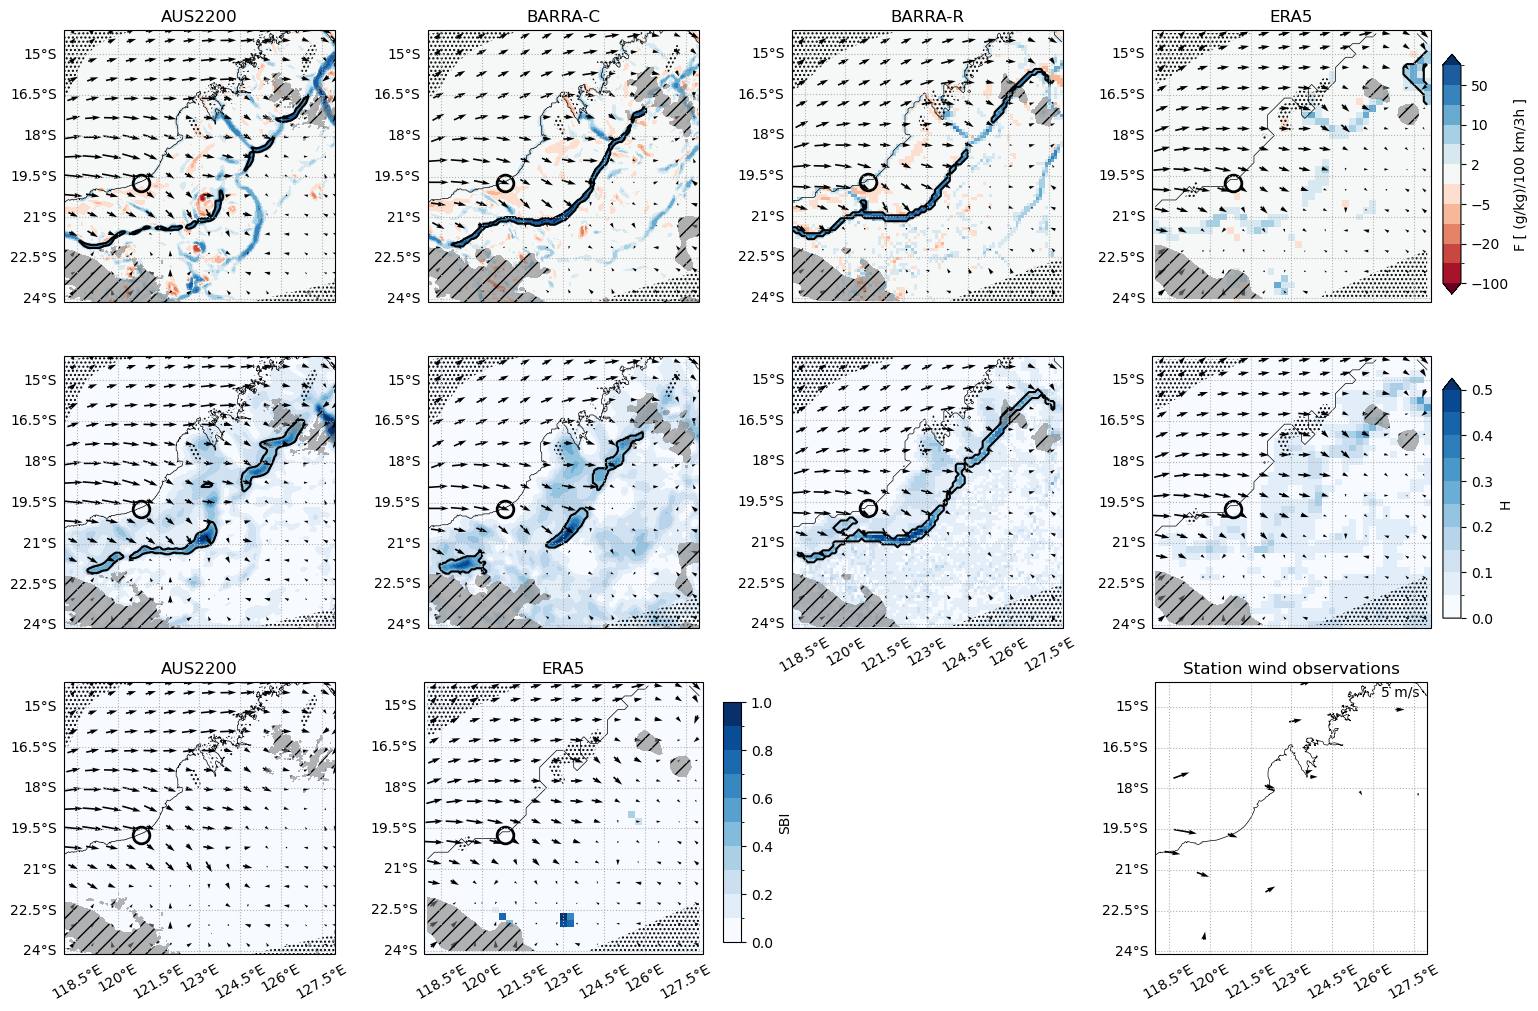

In [15]:
lat_slice = slice(-24.1,-14.1)
lon_slice = slice(118,128)
time = "2016-01-05 12:00"

exp_id = "mjo-elnino2016"
base_path = "/g/data/ng72/ab4502/"

state = ["NT","WA"]

plt.figure(figsize=[18,12])
plot_driver(scale=150,stn_id=4019)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/nwwa.jpeg",bbox_inches="tight",dpi=500)

In [11]:
def plot_ts(ax,time,stn_id,state):

    print("Plotting ",time,stn_id)
    
    ###############
    #LOAD OBS DATA#
    ###############
    stn_obs = xr.concat([load_obs.load_half_hourly_stn_obs(s, slice(
                          pd.to_datetime(time) - dt.timedelta(hours=12),
                          pd.to_datetime(time) + dt.timedelta(hours=12))) for s in state], 
                        dim="station")
    stn_lat=stn_obs.sel(station=stn_obs.bmid == stn_id).lati.values[0]
    stn_lon=stn_obs.sel(station=stn_obs.bmid == stn_id).long.values[0]
    
    #################
    #LOAD MODEL DATA#
    #################
    if stn_id == 27045:
        lat_slice = slice(-16.5,-10.5)
        lon_slice = slice(140,146)
    elif stn_id == 69148:
        lat_slice = slice(-40,-31)
        lon_slice = slice(143.1,152.1)    
    else:
        lat_slice = slice(stn_lat-0.5,stn_lat+0.5)
        lon_slice = slice(stn_lon-0.5,stn_lon+0.5)
    aus2200_angle_ds, _, aus2200_uas, aus2200_vas, _, aus2200_vprime, _ = utils.load_aus2200_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path,
        exp_id)
    aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static(exp_id,lon_slice,lat_slice)
    
    barra_c_angle_ds, _, barra_c_uas, barra_c_vas, _, _, _ = utils.load_barra_c_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    barra_c_orog, barra_c_lsm = load_model_data.load_barra_static("AUST-04",lon_slice, lat_slice)
    
    barra_r_angle_ds, _, barra_r_uas, barra_r_vas, _, _, _ = utils.load_barra_r_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    barra_r_orog, barra_r_lsm = load_model_data.load_barra_static("AUS-11",lon_slice, lat_slice)
    
    era5_angle_ds, _, era5_uas, era5_vas, _, era5_vprime, _ = utils.load_era5_filtering_data(
        lon_slice,
        lat_slice,
        pd.to_datetime(time) - dt.timedelta(hours=12),
        pd.to_datetime(time) + dt.timedelta(hours=12),
        base_path)
    era5_orog, era5_lsm, _ = load_model_data.load_era5_static(lon_slice, lat_slice, time, time)    

    ##################
    #CALCULATE VPRIME#
    ##################   
    stn_theta = aus2200_angle_ds.sel(
        lat=stn_lat,
        lon=stn_lon,method="nearest").angle_interp.values
    uprime, vprime = sea_breeze_funcs.rotate_wind(
        stn_obs.sel(station=stn_obs.bmid == stn_id).u,
        stn_obs.sel(station=stn_obs.bmid == stn_id).v,
        stn_theta)
    aus2200_uprime, aus2200_vprime = sea_breeze_funcs.rotate_wind(
        aus2200_uas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        aus2200_vas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        aus2200_angle_ds.angle_interp.sel(lat=stn_lat,lon=stn_lon,method="nearest"))   
    barra_c_uprime, barra_c_vprime = sea_breeze_funcs.rotate_wind(
        barra_c_uas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        barra_c_vas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        barra_c_angle_ds.angle_interp.sel(lat=stn_lat,lon=stn_lon,method="nearest"))   
    barra_r_uprime, barra_r_vprime = sea_breeze_funcs.rotate_wind(
        barra_r_uas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        barra_r_vas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        barra_r_angle_ds.angle_interp.sel(lat=stn_lat,lon=stn_lon,method="nearest"))       
    era5_uprime, era5_vprime = sea_breeze_funcs.rotate_wind(
        era5_uas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        era5_vas.sel(lat=stn_lat,lon=stn_lon,method="nearest"),
        era5_angle_ds.angle_interp.sel(lat=stn_lat,lon=stn_lon,method="nearest"))       

    vprime.sel(time=vprime.time.dt.minute==0).plot(marker="o",ax=ax,color="k",label="Observed $u'$")
    aus2200_vprime.plot(ax=ax,lw=1,color="tab:purple",label="AUS2200")
    barra_c_vprime.plot(ax=ax,lw=1,color="tab:green",label="BARRA-C")
    barra_r_vprime.plot(ax=ax,lw=1,color="tab:orange",label="BARRA-R")
    era5_vprime.plot(ax=ax,lw=1,color="tab:blue",label="ERA5")
    ax.grid(ls=":")
    plt.title("")
    ax.set_ylabel("$u'$")
    ax.set_xlabel("")
    
    ax2 = ax.twinx()
    stn_obs.sel(station=stn_obs.bmid == stn_id).hus.plot(color="k",ls="--",ax=ax2,label="Observed $q$")
    ax2.set_ylabel("$q$")

base_path = "/g/data/ng72/ab4502/"
exp_id = "mjo-elnino2016"

fig=plt.figure(figsize=[12,20])



ax=plt.subplot(7,1,1)
time = "2016-01-06 08:00"; state=["WA"]; stn_id=9021; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Perth (Figure N)\nPerth Airport ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
fig.legend(loc="lower center",bbox_to_anchor=(0.5,0.06),ncols=6)

ax=plt.subplot(7,1,2)
time = "2016-01-07 07:00"; state=["WA"]; stn_id=9178; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Perth (Figure N)\nGingin Aerodrome ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
ax=plt.subplot(7,1,3)
time = "2016-01-07 06:00"; state=["QLD"]; stn_id=27045; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Cape York (Figure N)\n Weipa Aerodrome("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
ax=plt.subplot(7,1,4)
time = "2016-01-11 09:00"; state=["WA"]; stn_id=9542; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Nullabor Plains (Figure N)\nEsperance Aerodrome ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
ax=plt.subplot(7,1,5)
time = "2016-01-12 09:00"; state=["WA"]; stn_id=9542; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Nullabor Plains (Figure N)\nEsperance Aerodrome ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
ax=plt.subplot(7,1,6)
time = "2016-01-09 04:00"; state=["NSW-ACT"]; stn_id=69148; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Southeast Australia (Figure N)\nMoruya Airport ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
ax=plt.subplot(7,1,7)
time = "2016-01-05 08:00"; state=["WA"]; stn_id=4019; plot_ts(ax,time,stn_id,state); ax.text(0.98,0.75,"Northwest Western Australia (Figure N)\nMandora ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

plt.subplots_adjust(hspace=0.3)
plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/time_series.jpeg",bbox_inches="tight",dpi=500)

Plotting  2016-01-08 04:00 69148


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks

NameError: name 'ax' is not defined

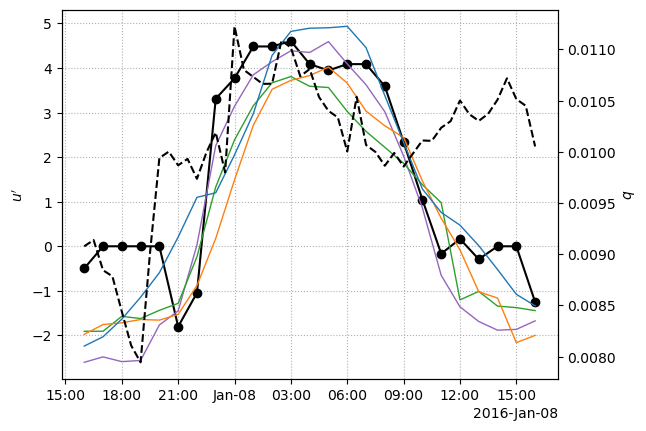

In [12]:
time = "2016-01-08 04:00"; state=["NSW-ACT"]; stn_id=69148; plot_ts(plt.axes(),time,stn_id,state); ax.text(0.98,0.75,"Southeast Australia (Figure N)\nMoruya Airport ("+str(stn_id)+")",ha="right",transform=ax.transAxes,bbox=dict(alpha=0.5,facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

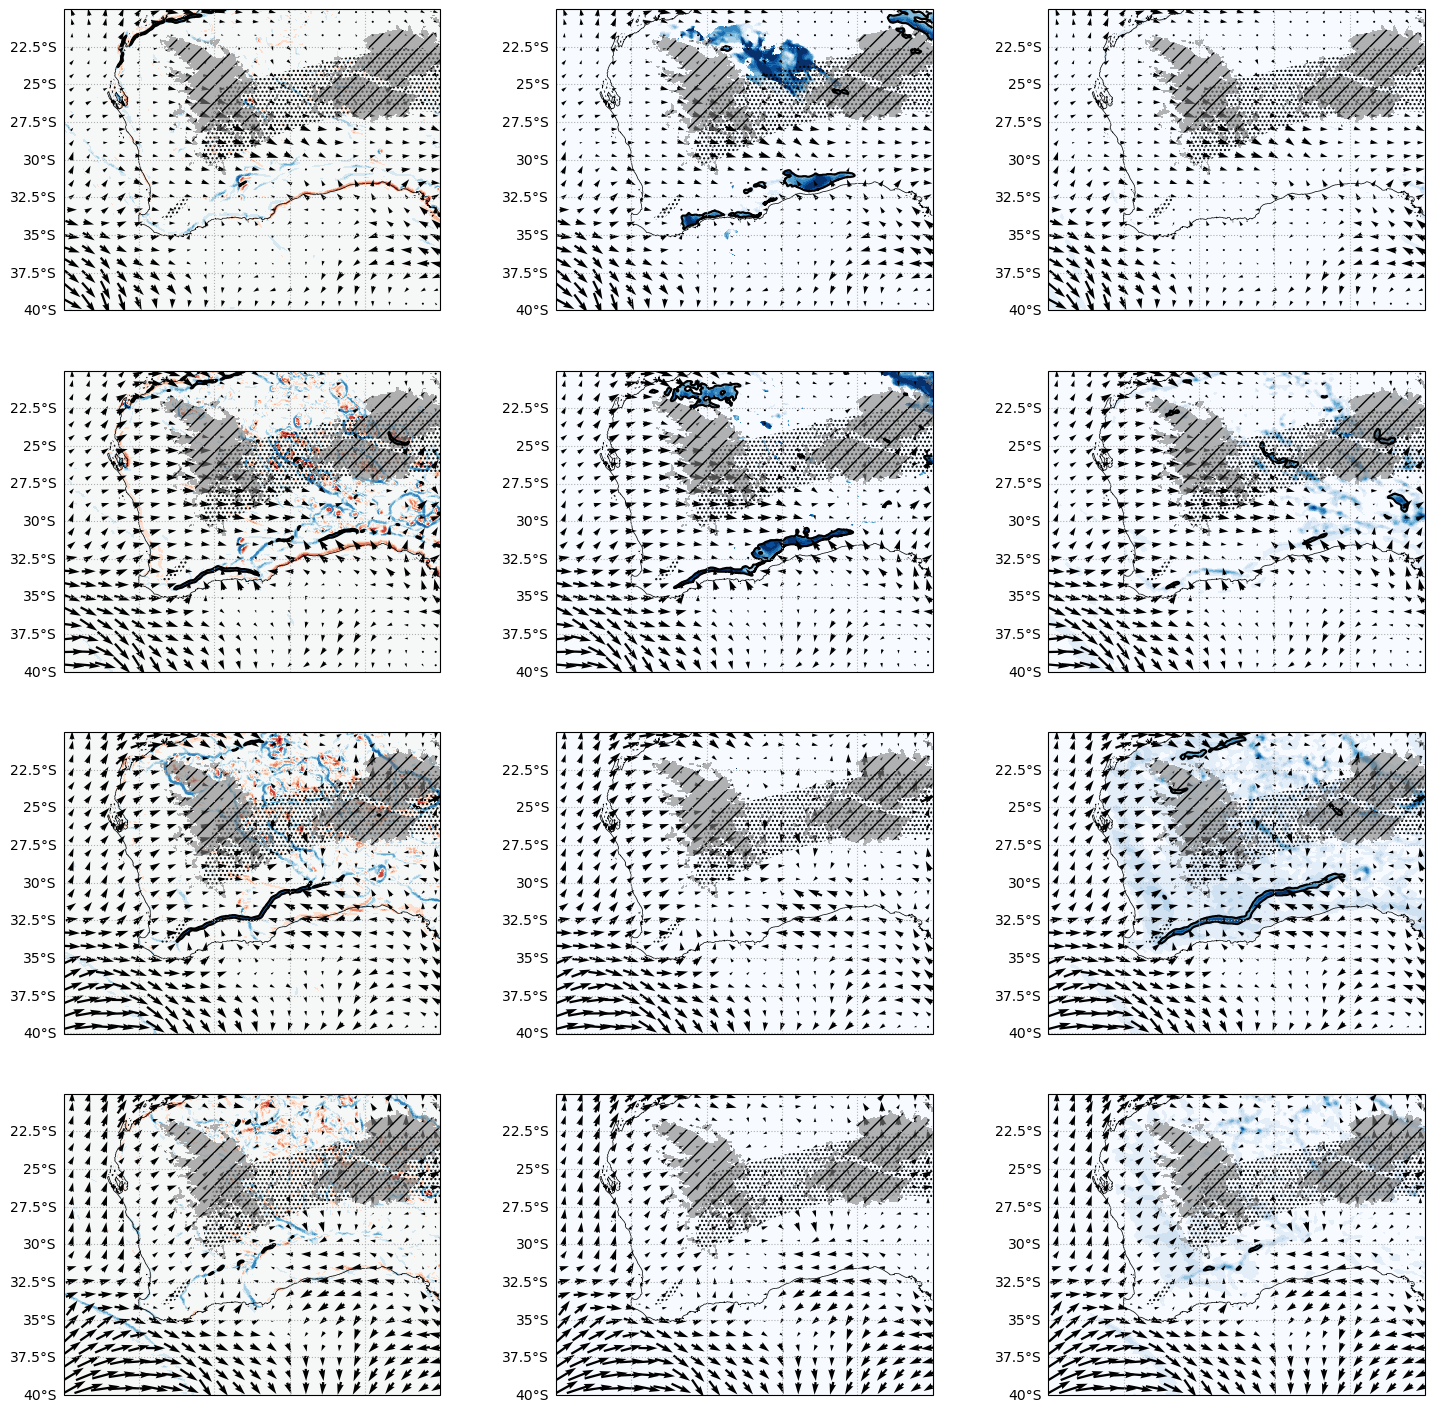

In [32]:
def plot_time_ev_driver(scale=200):

    aus2200_angle_ds, _, aus2200_uas, aus2200_vas, _, aus2200_vprime, _ = utils.load_aus2200_filtering_data(
        lon_slice,
        lat_slice,
        times[0],
        times[-1],
        base_path,
        exp_id)
    aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static(exp_id,lon_slice,lat_slice)
    

    plt.figure(figsize=[18,18])
    F_levels=[-100,-50,-20,-10,-5,-2,2,5,10,20,50,100]
    sbi_levels=np.linspace(0,1,11)
    fuzzy_levels=np.linspace(0,0.5,11)

    aus2200_coarsen_u = int((lon_slice.stop-lon_slice.start) * 5 / 2.2)
    aus2200_coarsen_v = int((lat_slice.stop-lat_slice.start) * 5 / 2.2)
    barra_c_coarsen_u = int((lon_slice.stop-lon_slice.start) * 5 / 4)
    barra_c_coarsen_v = int((lat_slice.stop-lat_slice.start) * 5 / 4)
    barra_r_coarsen_u = int((lon_slice.stop-lon_slice.start) * 5 / 12)
    barra_r_coarsen_v = int((lat_slice.stop-lat_slice.start) * 5 / 12)
    era5_coarsen_u = int((lon_slice.stop-lon_slice.start) * 5 / 25)
    era5_coarsen_v = int((lat_slice.stop-lat_slice.start) * 5 / 25)

    
    for time,c in zip(times,[1,4,7,10]):
    
        ###########
        # AUS2200 #
        ###########
        
        ax=plt.subplot(4,3,c+0,projection=ccrs.PlateCarree())
        plot_case(
            ax,
            F_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            F_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_angle_ds.variance_interp,
            aus2200_orog,
            aus2200_lsm,
            scale=scale,
            levels=F_levels,
            cmap="RdBu",
            extend="both")
        
        ax=plt.subplot(4,3,c+1,projection=ccrs.PlateCarree())
        plot_case(
            ax,
            sbi_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            sbi_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_angle_ds.variance_interp,
            aus2200_orog,
            aus2200_lsm,
            scale=scale,
            levels=sbi_levels,
            cmap="Blues")
        
        ax=plt.subplot(4,3,c+2,projection=ccrs.PlateCarree())
        plot_case(
            ax,
            fuzzy_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            fuzzy_mask_list[0].sel(time=time,lat=lat_slice,lon=lon_slice),
            aus2200_uas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_vas.sel(time=time,lat=lat_slice,lon=lon_slice).coarsen({"lat":aus2200_coarsen_v,"lon":aus2200_coarsen_u},boundary="pad").mean(),
            aus2200_angle_ds.variance_interp,
            aus2200_orog,
            aus2200_lsm,
            scale=scale,
            levels=fuzzy_levels,
            extend="max",
            cmap="Blues")
    
    

lat_slice = slice(-40,-20)
lon_slice = slice(110,135)
# lat_slice = slice(-40,-30)
# lon_slice = slice(110,115)
times = [
    "2016-01-11 03:00",
    "2016-01-11 07:00",
    "2016-01-11 11:00",
    "2016-01-11 15:00",
]


plot_time_ev_driver()

In [ ]:
lat_slice = slice(-40,-20)
lon_slice = slice(110,135)
# lat_slice = slice(-40,-30)
# lon_slice = slice(110,115)
times = [
    "2016-01-12 03:00",
    "2016-01-12 06:00",
    "2016-01-12 09:00",
    "2016-01-12 12:00",
    "2016-01-12 15:00",
    "2016-01-12 18:00",
    "2016-01-12 21:00"]

aus2200_angle_ds, _, aus2200_uas, aus2200_vas, _, aus2200_vprime, _ = utils.load_aus2200_filtering_data(
            lon_slice,
            lat_slice,
            times[0],
            times[-1],
            base_path,
            exp_id)

plt.figure(figsize=[18,16])
cnt=1
for t in times:

    
    
    ax=plt.subplot(3,3,cnt,projection=ccrs.PlateCarree())
    F_mask_list[0].sel(time=t,lat=lat_slice,lon=lon_slice).plot(cmap="Blues")
    xr.Dataset({"u":aus2200_uas.sel(time=t).coarsen({"lat":40,"lon":40},boundary="pad").mean(),
                "v":aus2200_vas.sel(time=t).coarsen({"lat":40,"lon":40},boundary="pad").mean(),
                }).plot.quiver(
            ax=ax,
            x="lon",
            y="lat",
            u="u",
            v="v",
            scale=200)
    ax.coastlines()
    cnt=cnt+1

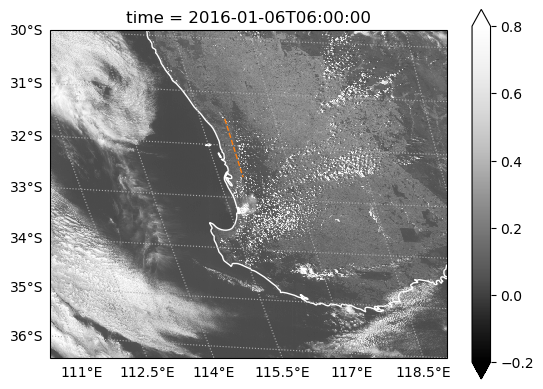

In [210]:
def load_sat(time,lon_slice,lat_slice):

    sat, pyproj_proj, ccrs_proj = load_obs.load_hima(pd.to_datetime(time))
    lons, lats = load_obs.get_lat_lons(sat, pyproj_proj)
    y_ind, x_ind = np.where((lons >= lon_slice.start) & (lons <= lon_slice.stop) & (lats <= lat_slice.stop) & (lats >= lat_slice.start))
    
    sat = sat.sel(
        y = slice(sat["y"][y_ind].max().values, sat["y"][y_ind].min().values),
        x = slice(sat["x"][x_ind].min().values, sat["x"][x_ind].max().values)
    ).channel_0003_corrected_reflectance

    return sat, ccrs_proj

def plot_sat(ax,ds):

    c = ds.plot(cmap="Greys_r",vmin=-0.2,vmax=0.8,ax=ax,add_colorbar=False)
    plt.colorbar(c,extend="both")
    ax.coastlines(color="white")
    ax.gridlines(draw_labels=["bottom","left"],ls=":")    

#sat, ccrs_proj = load_sat(time,lon_slice,lat_slice)
plot_sat(plt.axes(projection=ccrs_proj),sat)
plt.plot([116,116],[-31.5,-32.6],color="tab:orange",ls="--",lw=1,transform=ccrs.PlateCarree())